In [1]:
import numpy as np #для матричных вычислений
import pandas as pd #для анализа и предобработки данных
import matplotlib.pyplot as plt #для визуализации
import seaborn as sns #для визуализации

from sklearn import linear_model #линейные модели
from sklearn import metrics #метрики
from sklearn import preprocessing #предобработка
from sklearn.model_selection import train_test_split #разделение выборки

In [2]:
data = pd.read_csv('https://query.data.world/s/ixhho6cecxz7viysyqjlzu65keiuq6', encoding='latin-1')
data.head()

,avgAnnCount,avgDeathsPerYear,TARGET_deathRate,incidenceRate,medIncome,popEst2015,povertyPercent,studyPerCap,binnedInc,MedianAge,...,PctPrivateCoverageAlone,PctEmpPrivCoverage,PctPublicCoverage,PctPublicCoverageAlone,PctWhite,PctBlack,PctAsian,PctOtherRace,PctMarriedHouseholds,BirthRate
0,1397.0,469,164.9,489.8,61898,260131,11.2,499.748204,"(61494.5, 125635]",39.3,...,NaN,41.6,32.9,14.0,81.780529,2.594728,4.821857,1.843479,52.856076,6.118831
1,173.0,70,161.3,411.6,48127,43269,18.6,23.111234,"(48021.6, 51046.4]",33.0,...,53.8,43.6,31.1,15.3,89.228509,0.969102,2.246233,3.741352,45.372500,4.333096
2,102.0,50,174.7,349.7,49348,21026,14.6,47.560164,"(48021.6, 51046.4]",45.0,...,43.5,34.9,42.1,21.1,90.922190,0.739673,0.465898,2.747358,54.444868,3.729488
3,427.0,202,194.8,430.4,44243,75882,17.1,342.637253,"(42724.4, 45201]",42.8,...,40.3,35.0,45.3,25.0,91.744686,0.782626,1.161359,1.362643,51.021514,4.603841
4,57.0,26,144.4,350.1,49955,10321,12.5,0.000000,"(48021.6, 51046.4]",48.3,...,43.9,35.1,44.0,22.7,94.104024,0.270192,0.665830,0.492135,54.027460,6.796657


Набор данных содержит следующие столбцы:
* 

In [3]:
data.shape

(3047, 34)

Выведем информацию о пропусках и о типах данных

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3047 entries, 0 to 3046
Data columns (total 34 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   avgAnnCount              3047 non-null   float64
 1   avgDeathsPerYear         3047 non-null   int64  
 2   TARGET_deathRate         3047 non-null   float64
 3   incidenceRate            3047 non-null   float64
 4   medIncome                3047 non-null   int64  
 5   popEst2015               3047 non-null   int64  
 6   povertyPercent           3047 non-null   float64
 7   studyPerCap              3047 non-null   float64
 8   binnedInc                3047 non-null   object 
 9   MedianAge                3047 non-null   float64
 10  MedianAgeMale            3047 non-null   float64
 11  MedianAgeFemale          3047 non-null   float64
 12  Geography                3047 non-null   object 
 13  AvgHouseholdSize         3047 non-null   float64
 14  PercentMarried          

Строим гистограммы и коробчатые диаграммы числовых признаков

In [5]:
types = data.dtypes
num_features = list(types[types != 'object'].index)
num_features

['avgAnnCount',
 'avgDeathsPerYear',
 'TARGET_deathRate',
 'incidenceRate',
 'medIncome',
 'popEst2015',
 'povertyPercent',
 'studyPerCap',
 'MedianAge',
 'MedianAgeMale',
 'MedianAgeFemale',
 'AvgHouseholdSize',
 'PercentMarried',
 'PctNoHS18_24',
 'PctHS18_24',
 'PctSomeCol18_24',
 'PctBachDeg18_24',
 'PctHS25_Over',
 'PctBachDeg25_Over',
 'PctEmployed16_Over',
 'PctUnemployed16_Over',
 'PctPrivateCoverage',
 'PctPrivateCoverageAlone',
 'PctEmpPrivCoverage',
 'PctPublicCoverage',
 'PctPublicCoverageAlone',
 'PctWhite',
 'PctBlack',
 'PctAsian',
 'PctOtherRace',
 'PctMarriedHouseholds',
 'BirthRate']

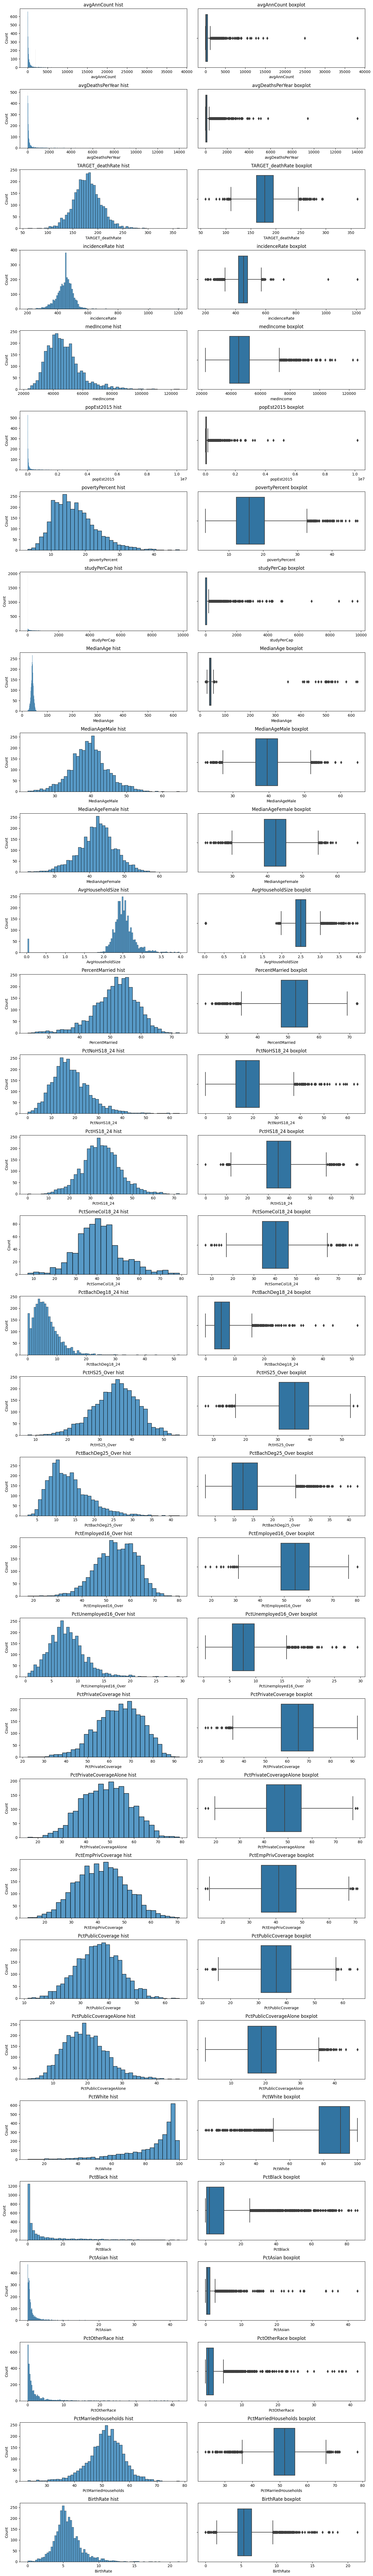

In [6]:
n = len(num_features) # определяем количество числовых признаков
fig, axes = plt.subplots(n, 2, figsize=(14, n*3))
# цикл для всех признаков из списка
for i, feature in enumerate(num_features):
    # строим гистограмму распределения признака
    histplot = sns.histplot(data=data, x=feature, ax=axes[i][0])
    histplot.set_title(f'{feature} hist')
    # строим коробчатую диаграмму распределения признака
    boxplot = sns.boxplot(data=data, x=feature, ax=axes[i][1])
    boxplot.set_title(f'{feature} boxplot')
plt.tight_layout() # выравнивание графиков

**Очистка данных от выбросов**

In [2]:
#Объявляем функцию, реализующую фильтрацию выбросов по методу z-отклонений
def outliers_z_score(data, feature, log_scale=False):
    """Возвращает данные датасета являющиеся выбросами, возвращает датасет без выбросов.
    В основе лежит метод трех сигм.

    Args:
        data (pd.DataFrame):            датасет, в котором нужно провести очистку данных
        feature (str):                  признак датасета, по которому нужно проводить очистку
        log_scale (bool, optional):     Defaults to False. Необходимо ли проводить логарифмирование с признаком

    Returns:
        outliers(pd.DataFrame):         признаки датасета, являющиеся выбросами
        cleaned(pd.DataFrame):          признаки датасета, без выбросов
    """
    if log_scale == True:
        x = np.log(data[feature] + 1)
    else:
        x = data[feature]
    mu = x.mean()
    sigma = x.std()
    lower_bound = mu - 3 * sigma
    upper_bound = mu + 3 * sigma
    outliers = data[(x < lower_bound) | (x > upper_bound)]
    cleaned = data[(x > lower_bound) & (x < upper_bound)]
    return outliers, cleaned

# производим очистку
outliers, temp_cleaned = outliers_z_score(data, 'avgAnnCount', log_scale=True)
# outliers, temp_cleaned = outliers_z_score(temp_cleaned, 'mileage', log_scale=True)
# outliers, temp_cleaned = outliers_z_score(temp_cleaned, 'mpg', log_scale=True)

print('Shape before cleaning outliers: {}'.format(data.shape))
print('Shape after cleaning outliers: {}'.format(temp_cleaned.shape))

NameError: name 'data' is not defined

**Кодируем категориальные признаки**

In [88]:
data['smoker'] = data['smoker'].apply(lambda x: 1 if x == 'yes' else 0)
data['sex'] = data['sex'].apply(lambda x: 0 if x == 'female' else 1)

# оставшиеся категориальные признаки кодируемс с помощью OneHot
data = pd.get_dummies(data)
data.head()

,age,sex,bmi,children,smoker,charges,region_northeast,region_northwest,region_southeast,region_southwest
0,19,0,27.900,0,1,16884.92400,0,0,0,1
1,18,1,33.770,1,0,1725.55230,0,0,1,0
2,28,1,33.000,3,0,4449.46200,0,0,1,0
3,33,1,22.705,0,0,21984.47061,0,1,0,0
4,32,1,28.880,0,0,3866.85520,0,1,0,0


Выделяем факторы и целевой признак в отдельные таблицы

In [89]:
features = data.drop(columns='charges').columns
X, y = data[features], data['charges']

**Начинаем работу над моделью**

Разделяем набор данных на тренировочную и тестовую

In [90]:
# разделяем датасет на тренировочную и тестовую выборки. Метод train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, # таблица с наблюдениями и вектор правильных овтетов
    test_size=0.2,
    random_state=42
)

# выводим размеры полученых выборок
print(f'Train shape: - X:{X_train.shape}: y - {y_train.shape}')
print(f'Test shape: - X:{X_test.shape}: y - {y_test.shape}')

Train shape: - X:(1070, 9): y - (1070,)
Test shape: - X:(268, 9): y - (268,)


Обучаем модель линейной регрессии аналитическим методом

In [91]:
# создаем объект класса
lr_analyt = linear_model.LinearRegression()
# обучаем модель на тренировочных данных
lr_analyt.fit(X_train, y_train)
# находим чему равны параметры
print('w0: {}'.format(lr_analyt.intercept_)) #свободный член w0
print('w1: {}'.format(lr_analyt.coef_))      #остальные параметры модели w1, w2, ..., wm

w0: -12390.804294570278
w1: [ 2.56975706e+02 -1.85916916e+01  3.37092552e+02  4.25278784e+02
  2.36511289e+04  4.59585244e+02  8.89079180e+01 -1.98279052e+02
 -3.50214110e+02]


С помощью модели делаем предсказание на тренировочной выборке

Создаем функцию вывода расчитанных метрик

In [102]:
def print_metrics(y_train, y_train_predict, y_test, y_test_predict):
    """Выводит информацию о метриках

    Args:
        y_train (_type_): Series
        y_train_predict (_type_): Series
        y_test (_type_): Series
        y_test_predict (_type_): Series
    """
    print(f'Train R^2: {round(metrics.r2_score(y_train, y_train_predict), 4)}')
    print(f'Train MAE: {round(metrics.mean_absolute_error(y_train, y_train_predict), 3)}')
    print(f'Train MAPE: {round(metrics.mean_absolute_percentage_error(y_train, y_train_predict), 3)}')
    print()
    
    print(f'Test R^2: {round(metrics.r2_score(y_test, y_test_predict), 4)}')
    print(f'Test MAE: {round(metrics.mean_absolute_error(y_test, y_test_predict), 3)}')
    print(f'Test MAPE: {round(metrics.mean_absolute_percentage_error(y_test, y_test_predict), 3)}')

In [93]:
y_train_predict = lr_analyt.predict(X_train)
y_test_predict = lr_analyt.predict(X_test)

# выводим метрики
print_metrics(y_train, y_train_predict, y_test, y_test_predict)

Train R^2: 0.742
Train MAE: 4208.235
Train MAPE: 0.422

Test R^2: 0.784
Test MAE: 4181.194
Test MAPE: 0.469


Строим диаграмму boxplot для визуализации ошибок модели линейной регрессии на тренировочной и тестовой выборках.

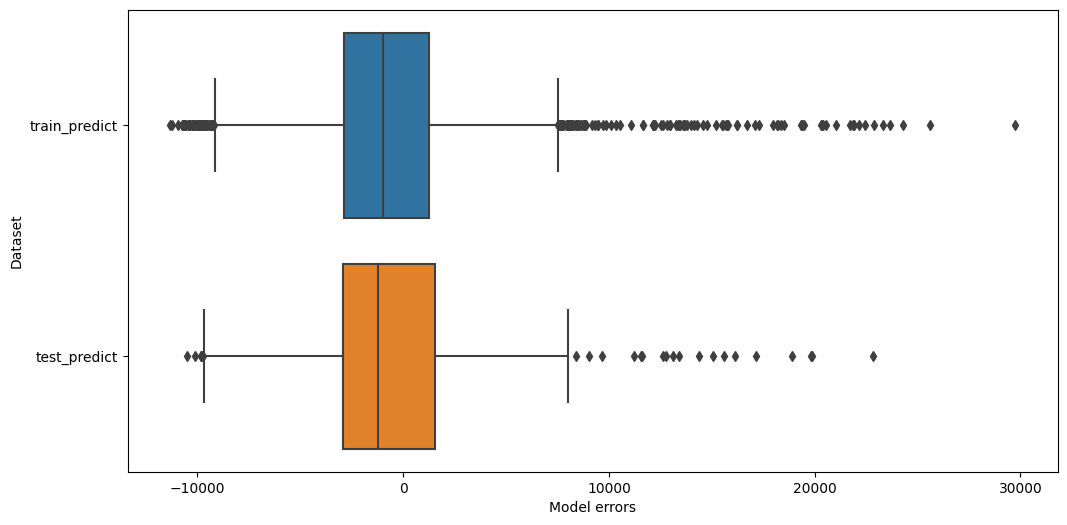

In [94]:
#Визуализируем ошибки
fig, ax = plt.subplots(figsize=(12, 6))     # фигура + координатная плоскость
#Ошибки модели на одном факторе LSTAT
y_errors_train = y_train - y_train_predict
y_errors_test = y_test - y_test_predict

#Для удобства визуализации составим DataFrame из ошибок
errors_df = pd.DataFrame(
    {'train_predict': y_errors_train, 
     'test_predict': y_errors_test
    }
)
#Строим boxplot для ошибок
sns.boxplot(data=errors_df, orient='h', ax=ax)
ax.set_xlabel('Model errors') #название оси абсцисс
ax.set_ylabel('Dataset'); #название оси ординат

**Проведем нормализацию**

In [95]:
# создаем объект класса
scaller = preprocessing.MinMaxScaler()
# вычисляем параметры нормализации
scaller.fit(X_train)
# производим преобразования
X_train_scaled = scaller.transform(X_train)
X_test_scaled = scaller.transform(X_test)

**Создаем полиномиальные признаки**

In [96]:
poly = preprocessing.PolynomialFeatures(degree=2, include_bias=False)
# вычисляем параметры
poly.fit(X_train_scaled)
# производим преобразования для каждой выборки
X_train_scaled_poly = poly.transform(X_train_scaled)
X_test_scaled_poly = poly.transform(X_test_scaled)

print('Train shape: {}'.format(X_train_scaled_poly.shape))
print('Test shape: {}'.format(X_test_scaled_poly.shape))

Train shape: (1070, 54)
Test shape: (268, 54)


**Обучаем модель на полиномиальных признаках**

In [103]:
# создаем экземпляр класса
lr_analyt_poly = linear_model.LinearRegression()
# обучаем модель
lr_analyt_poly.fit(X_train_scaled_poly, y_train)
# предсказываем значения
y_train_predict_poly = lr_analyt_poly.predict(X_train_scaled_poly)
y_test_predict_poly = lr_analyt_poly.predict(X_test_scaled_poly)

# выводим метрики
print_metrics(y_train, y_train_predict_poly, y_test, y_test_predict_poly)

Train R^2: 0.8418
Train MAE: 2906.12
Train MAPE: 0.296

Test R^2: 0.8665
Test MAE: 2741.678
Test MAPE: 0.304


Выводим значения коэффициентов полученой модели

In [104]:
print('w0: {}'.format(lr_analyt_poly.intercept_)) #свободный член w0
print('w1: {}'.format(lr_analyt_poly.coef_))      #остальные параметры модели w1, w2, ..., wm

w0: 4662166100954783.0
w1: [-3.51760358e+16  1.61021746e+15  2.47615914e+15 -4.81004112e+15
  1.29275952e+14 -3.52012791e+15 -2.48431178e+15 -2.59881721e+15
 -1.45044066e+15  8.44800000e+03  8.02000000e+02  9.72000000e+02
 -1.67600000e+03  1.70000000e+02  3.51760358e+16  3.51760358e+16
  3.51760358e+16  3.51760358e+16 -9.23535566e+14  6.51750000e+02
 -1.23750000e+03  2.63000000e+02 -6.86681899e+14 -6.86681899e+14
 -6.86681899e+14 -6.86681899e+14 -9.69775000e+03  1.55693750e+03
  5.48399844e+04 -2.47615914e+15 -2.47615914e+15 -2.47615914e+15
 -2.47615914e+15 -2.09825000e+03 -2.23150000e+03  4.81004112e+15
  4.81004112e+15  4.81004112e+15  4.81004112e+15  2.54047741e+13
 -1.54680726e+14 -1.54680726e+14 -1.54680726e+14 -1.54680726e+14
 -1.14203819e+15  0.00000000e+00  0.00000000e+00  0.00000000e+00
 -2.17785432e+15  0.00000000e+00  0.00000000e+00 -2.06334889e+15
  0.00000000e+00 -3.21172544e+15]


Значения коэффициентов очень высокие, модель неустойчива, необходима регуляризация.

**Строим модель с L1-регуляризацией (Lasso)**

In [106]:
# инициализируем объект класса
lr_lasso = linear_model.Lasso(max_iter=2000)
# обучаем модель
lr_lasso.fit(X_train_scaled_poly, y_train)
# предсказываем
y_train_predict_poly_lasso = lr_lasso.predict(X_train_scaled_poly)
y_test_predict_poly_lasso = lr_lasso.predict(X_test_scaled_poly)

# выводим метрики
print_metrics(y_train, y_train_predict_poly_lasso, y_test, y_test_predict_poly_lasso)

Train R^2: 0.8418
Train MAE: 2890.473
Train MAPE: 0.294

Test R^2: 0.8668
Test MAE: 2719.334
Test MAPE: 0.301


Выводим значения коэффициентов полученой модели

In [112]:
print('w0: {}'.format(lr_analyt_poly.intercept_)) #свободный член w0
print(f'w1: {np.round(lr_analyt_poly.coef_, 2)}')      #остальные параметры модели w1, w2, ..., wm

w0: 4662166100954783.0
w1: [-3.51760358e+16  1.61021746e+15  2.47615914e+15 -4.81004112e+15
  1.29275952e+14 -3.52012791e+15 -2.48431178e+15 -2.59881721e+15
 -1.45044066e+15  8.44800000e+03  8.02000000e+02  9.72000000e+02
 -1.67600000e+03  1.70000000e+02  3.51760358e+16  3.51760358e+16
  3.51760358e+16  3.51760358e+16 -9.23535566e+14  6.51750000e+02
 -1.23750000e+03  2.63000000e+02 -6.86681899e+14 -6.86681899e+14
 -6.86681899e+14 -6.86681899e+14 -9.69775000e+03  1.55694000e+03
  5.48399800e+04 -2.47615914e+15 -2.47615914e+15 -2.47615914e+15
 -2.47615914e+15 -2.09825000e+03 -2.23150000e+03  4.81004112e+15
  4.81004112e+15  4.81004112e+15  4.81004112e+15  2.54047741e+13
 -1.54680726e+14 -1.54680726e+14 -1.54680726e+14 -1.54680726e+14
 -1.14203819e+15  0.00000000e+00  0.00000000e+00  0.00000000e+00
 -2.17785432e+15  0.00000000e+00  0.00000000e+00 -2.06334889e+15
  0.00000000e+00 -3.21172544e+15]


Значения коэффициентов по прежнему высокие. Незнначительное количество коэффициентов обнулилось, т.к. модель посчитала, что они не важны в расчете

**Строим модель с L2-регуляризацией (Lasso)**

In [114]:
# инициализируем объект класса
lr_ridge = linear_model.Ridge(max_iter=2000)
# обучаем модель
lr_ridge.fit(X_train_scaled_poly, y_train)
# предсказываем
y_train_predict_poly_ridge = lr_ridge.predict(X_train_scaled_poly)
y_test_predict_poly_ridge = lr_ridge.predict(X_test_scaled_poly)

# выводим метрики
print_metrics(y_train, y_train_predict_poly_ridge, y_test, y_test_predict_poly_ridge)

Train R^2: 0.8386
Train MAE: 2948.804
Train MAPE: 0.295

Test R^2: 0.8633
Test MAE: 2860.555
Test MAPE: 0.314


**Строим модель с L2-регуляризацией (Lasso) с учетом логарифмирования целевого признака**

In [115]:
# инициализируем объект класса
lr_ridge = linear_model.Ridge(max_iter=2000)
# обучаем модель
lr_ridge.fit(X_train_scaled_poly, np.log(y_train))
# предсказываем
y_train_predict_poly_ridge = np.exp(lr_ridge.predict(X_train_scaled_poly))
y_test_predict_poly_ridge = np.exp(lr_ridge.predict(X_test_scaled_poly))

# выводим метрики
print_metrics(y_train, y_train_predict_poly_ridge, y_test, y_test_predict_poly_ridge)

Train R^2: 0.8158
Train MAE: 2684.509
Train MAPE: 0.182

Test R^2: 0.8569
Test MAE: 2424.021
Test MAPE: 0.179
